In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear

import torch_geometric.nn as pyg_nn
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(precision=5, suppress=True)
torch.set_printoptions(precision=5, sci_mode=False)

In [2]:
def slice_dataset(dataset_in, percentage):
    data_size = len(dataset_in)
    index = [i for i in range(len(dataset))]
    np.random.shuffle(index)
    dataset_random = dataset_in[index,:]
    return dataset_random[:int(data_size*percentage/100)],dataset_random[int(data_size*percentage/100):]

def make_dataset(dataset, n_bus):
    x_raw_1, y_raw_1 = [], []
    x_raw, y_raw = [], []

    for i in range(len(dataset)):
        y_raw_1=[dataset[i,9600]]
        for n in range(n_bus):
            x_raw_1.append(list(dataset[i,400*n:400*n+400])) 
        
        x_raw.append(list(x_raw_1))
        y_raw.append(y_raw_1)
        x_raw_1, y_raw_1 = [], []

    x_raw = torch.tensor(x_raw, dtype=torch.float)
    y_raw = torch.tensor(y_raw, dtype=torch.float)
    return x_raw, y_raw


def NRMSE(yhat,y):
    return torch.sqrt(torch.mean(((yhat-y)/torch.std(yhat,0))**2))

def MSE(yhat,y):
    return torch.mean((yhat-y)**2)

In [3]:
dataset = pd.read_excel('train_3rd_wrv_SNR45db.xlsx').values

In [4]:
dataset_0 = np.zeros([1100,9601])
#dataset_10b=np.concatenate((dataset[:,0:400],dataset[:,600:800],dataset[:,1000:1800],dataset[:,2000:2200],dataset[:,2400:2600],dataset[:,2600:3000],dataset[:,3200:3400],dataset[:,3600:4400],dataset[:,4600:4800],dataset[:,5000:5201]),axis=1)
#RoCoF Features
dataset_0[:,0:200]=dataset[:,0:200] # bus 1 nodal features
dataset_0[:,200:400]=dataset[:,2600:2800] # bus 1 nodal features
dataset_0[:,400:600]=dataset[:,200:400] # bus 2 nodal features
dataset_0[:,600:800]=dataset[:,2800:3000] # bus 2 nodal features

dataset_0[:,4800:5000]=dataset[:,600:800] # bus 13 nodal features
dataset_0[:,5200:5400]=dataset[:,3200:3400] # bus 13 nodal features

dataset_0[:,6000:6200]=dataset[:,1200:1400] # bus 16 nodal features
dataset_0[:,6200:6400]=dataset[:,3800:4000] # bus 16 nodal features

dataset_0[:,6800:7000]=dataset[:,1400:1600] # bus 18 nodal features
dataset_0[:,7000:7200]=dataset[:,4000:4200] # bus 18 nodal features

dataset_0[:,8000:8200]=dataset[:,1600:1800] # bus 21 nodal features
dataset_0[:,8200:8400]=dataset[:,4200:4400] # bus 21 nodal features

dataset_0[:,8400:8600]=dataset[:,2000:2200] # bus 22,23 nodal features
dataset_0[:,8600:8800]=dataset[:,4600:4800] # bus 22,23 nodal features

dataset_0[:,8800:9000]=dataset[:,2400:2600] # bus 22,23 nodal features
dataset_0[:,9000:9200]=dataset[:,5000:5200] # bus 22,23 nodal features
dataset_0[:,9600:9601]=dataset[:,7000:7001] # labels
print(dataset_0[0])

[0.86086 0.85973 0.85676 ... 0.      0.      3.5    ]


In [5]:
train_percentage = 80
val_percentage = 20

print(dataset.shape)
train_dataset,val_dataset  = slice_dataset(dataset_0, train_percentage)
#val_dataset = slice_dataset(dataset_0, val_percentage)

n_bus = 24

#actual data
x_raw_train, y_raw_train = make_dataset(train_dataset,n_bus)
x_raw_val, y_raw_val = make_dataset(val_dataset, n_bus)

(1100, 7001)


In [6]:
x_train, y_train = x_raw_train, y_raw_train
x_val, y_val = x_raw_val, y_raw_val
edge_index = torch.tensor([[0, 1, 0, 2, 0, 4, 1, 3, 1, 5, 2, 8, 2,23, 3, 8, 4, 9, 5, 9, 6, 7, 7, 8, 7, 9, 8,10, 8,11, 9,10, 9,11,10,12,10,13,11,12,11,22,12,22,13,15,14,15,14,20,14,23,15,16,15,18,16,17,16,21,17,20,18,19,19,22,20,21],
                           [1, 0, 2, 0, 4, 0, 3, 1, 5, 1, 8, 2,23, 2, 8, 3, 9, 4, 9, 5, 7, 6, 8, 7, 9, 7,10, 8,11, 8,10, 9,11, 9,12,10,13,10,12,11,22,11,22,12,15,13,15,14,20,14,23,14,16,15,18,15,17,16,21,16,20,17,19,18,22,19,21,20]], dtype=torch.long)

data_train_list, data_val_list = [], []
for i,_ in enumerate(x_train):
    data_train_list.append(Data(x=x_train[i], y=y_train[i], edge_index=edge_index))
for i,_ in enumerate(x_val):
    data_val_list.append(Data(x=x_val[i], y=y_val[i], edge_index=edge_index))

train_loader = DataLoader(data_train_list, batch_size=1)
val_loader = DataLoader(data_val_list, batch_size=1)

D:\Anaconda\envs\python38\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [7]:
class My_GNN_NN(torch.nn.Module):
    def __init__(self, node_size=None, feat_in=None, feat_size1=None, hidden_size1=None, output_size=None):
        super(My_GNN_NN, self).__init__()
        self.feat_in = feat_in if feat_in is not None else 400
        self.feat_size1 = feat_in if feat_in is not None else 64
        self.hidden_size1 = hidden_size1 if hidden_size1 is not None else 64
        self.output_size = output_size if output_size is not None else 1
        
        self.conv1 = GCNConv(feat_in, feat_size1)
        self.lin1 = Linear(node_size*feat_size1, hidden_size1)
        self.lin2 = Linear(hidden_size1, output_size)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = torch.tanh(x)

        x = x.flatten(start_dim = 0)
        x = self.lin1(x)
        x = torch.tanh(x)

        x = self.lin2(x)

        return x
    
    def save_weights(self, model, name):
        torch.save(model, name)

In [8]:
feat_in = 400
feat_size1 = 64
hidden_size1 = 128
output_size = 1
lr = 0.0001

model = My_GNN_NN(n_bus, feat_in, feat_size1, hidden_size1, output_size)
for name, param in model.named_parameters():
  print(name)
  print(param.size())

param = sum(p.numel() for p in model.parameters() if p.requires_grad)
param

conv1.bias
torch.Size([64])
conv1.lin.weight
torch.Size([64, 400])
lin1.weight
torch.Size([128, 1536])
lin1.bias
torch.Size([128])
lin2.weight
torch.Size([1, 128])
lin2.bias
torch.Size([1])


222529

In [9]:
feat_in = 400
feat_size1 = 64
hidden_size1 = 128
output_size =1
lr = 0.0001

model = My_GNN_NN(n_bus, feat_in, feat_size1, hidden_size1, output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_loss_list, val_loss_list = [], []

count=0
patience=1000
lossMin = 1e10
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for epoch in range(1001):
    model.train()
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        y_train_prediction = model(batch)
        loss = MSE(y_train_prediction, batch.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.num_graphs
    train_loss /= len(train_loader.dataset)
    train_loss_list.append(train_loss)

    model.eval()
    val_loss=0
    for batch in val_loader:
        y_val_prediction = model(batch)
        loss = MSE(y_val_prediction, batch.y)
        val_loss += loss.item() * batch.num_graphs
    val_loss /= len(val_loader.dataset)
    val_loss_list.append(val_loss)

    #early stopping
    if (val_loss < lossMin):
        lossMin = val_loss
        count = 0
        best_epoch = epoch
        best_train_loss = train_loss
        best_val_loss = val_loss
        model.save_weights(model, "Inertia_GNN_NN_model.pt")
    else:
        count+=1
        if(count>patience):
            print("early stop at epoch {:d}    train loss: {:.7f}    val loss: {:.7f}".format(epoch, train_loss, val_loss))
            print("best val at epoch {:d}    train loss: {:.7f}    val loss: {:.7f}".format(best_epoch, best_train_loss, best_val_loss))
            break
    
    if (train_loss <= 0):
        print("min train loss at epoch {:d}    train loss: {:.7f}    val loss: {:.7f}".format(epoch, train_loss, val_loss))
        break

    if (epoch % 10) == 0:
        print('epoch: {:d}    train loss: {:.7f}    val loss: {:.7f}'.format(epoch, train_loss, val_loss))

epoch: 0    train loss: 2.8116890    val loss: 2.2388445
epoch: 10    train loss: 0.1349994    val loss: 0.2473383
epoch: 20    train loss: 0.0440006    val loss: 0.2244381
epoch: 30    train loss: 0.0261421    val loss: 0.1964363
epoch: 40    train loss: 0.0164654    val loss: 0.1877782
epoch: 50    train loss: 0.0115441    val loss: 0.1855387
epoch: 60    train loss: 0.0106086    val loss: 0.1800885
epoch: 70    train loss: 0.0097294    val loss: 0.1851507
epoch: 80    train loss: 0.0088302    val loss: 0.1830953
epoch: 90    train loss: 0.0080866    val loss: 0.1750975
epoch: 100    train loss: 0.0071330    val loss: 0.1656498
epoch: 110    train loss: 0.0053554    val loss: 0.1613601
epoch: 120    train loss: 0.0063520    val loss: 0.1574971
epoch: 130    train loss: 0.0062930    val loss: 0.1552222
epoch: 140    train loss: 0.0053455    val loss: 0.1533935
epoch: 150    train loss: 0.0045494    val loss: 0.1523577
epoch: 160    train loss: 0.0050564    val loss: 0.1441611
epoch: 1

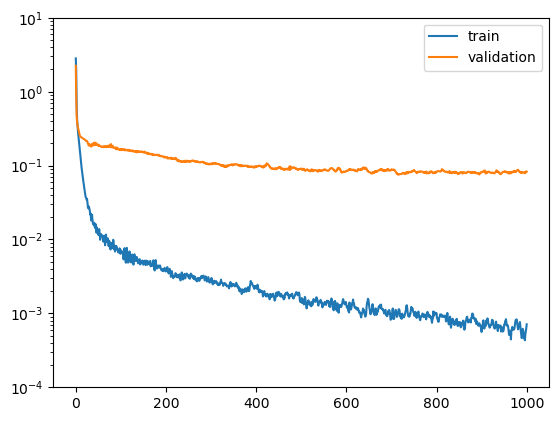

last epoch: 1000, train loss: 0.0007105, val loss: 0.0824505
best epoch: 715, train loss: 0.0010259, val loss: 0.0754196


In [11]:
#plt.title('GNN NN on power flow dataset')
plt.plot(train_loss_list, label="train")
plt.plot(val_loss_list, label="validation")
plt.yscale('log')
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
plt.ylim(0.0001,10)
plt.legend(loc='best')
plt.savefig('GNN_trainingSNR45db.png',dpi=1000)
plt.show()

print('last epoch: {:d}, train loss: {:.7f}, val loss: {:.7f}'.format(epoch, train_loss, val_loss))
print('best epoch: {:d}, train loss: {:.7f}, val loss: {:.7f}'.format(best_epoch, best_train_loss, best_val_loss))

In [12]:
model.eval()

y_train_prediction_1 = model(train_loader.dataset[0])
train_loss_1 = MSE(y_train_prediction_1, y_raw_train[0])
print("[1 datapoint] Train output ground-truth: \n" + str(y_raw_train[0].detach().numpy()))
print("[1 datapoint] Train output prediction: \n" + str(y_train_prediction_1.detach().numpy()))
print('[1 datapoint] Train loss (MSE): {:.7f}'.format(train_loss_1))

train_loss = 0
for batch in train_loader:
    pred = model(batch)
    loss = MSE(pred, batch.y)
    train_loss += loss.item() * batch.num_graphs
train_loss /= len(train_loader.dataset)
print('Train loss (MSE): {:.7f}'.format(train_loss))

print("=========================================================================")

y_val_prediction_1 = model(val_loader.dataset[0])
val_loss_1 = MSE(y_val_prediction_1, y_raw_train[0])
print("[1 datapoint] Val output ground-truth: \n" + str(y_raw_val[0].detach().numpy()))
print("[1 datapoint] Val output prediction: \n" + str(y_val_prediction_1.detach().numpy()))
print('[1 datapoint] Val loss (MSE): {:.7f}'.format(val_loss_1))

[1 datapoint] Train output ground-truth: 
[3.5]
[1 datapoint] Train output prediction: 
[3.54206]
[1 datapoint] Train loss (MSE): 0.0017691
Train loss (MSE): 0.0061172
[1 datapoint] Val output ground-truth: 
[6.5]
[1 datapoint] Val output prediction: 
[6.81323]
[1 datapoint] Val loss (MSE): 10.9774904


Text(0.5, 0, 'Absolute Error')

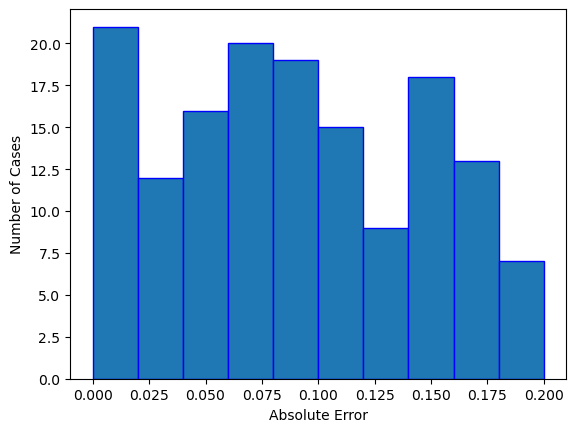

In [13]:
err = []
for i in range(0, len(val_loader.dataset)):
    y_val_prediction = model(val_loader.dataset[i])
    err.append(y_val_prediction.detach().numpy()-y_raw_val[i].detach().numpy())
plt.hist(np.abs(np.array(err)).reshape(-1),bins=[0, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18, 0.20],edgecolor='b')
plt.ylabel('Number of Cases')
plt.xlabel('Absolute Error')

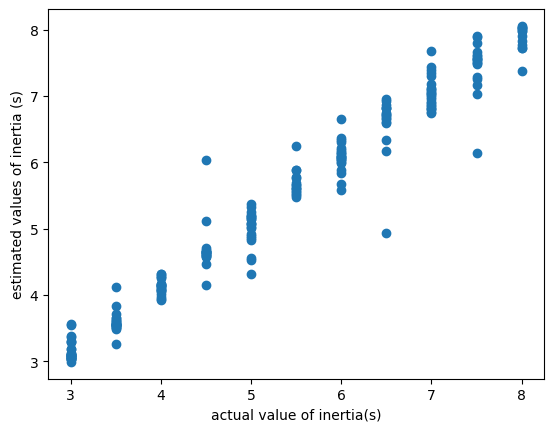

In [14]:
y_predict = []
for i in range(0, len(val_loader.dataset)):
    y_val_prediction = model(val_loader.dataset[i])
    y_predict.append(y_val_prediction.detach().numpy())

plt.xlabel('actual value of inertia(s)')
plt.ylabel('estimated values of inertia (s)')
plt.scatter(y_raw_val,y_predict)
plt.savefig('Scatters_CNN_Delay_0.0.png',dpi=1000)
plt.show()

In [15]:
y_raw_val.detach().numpy()
percent = np.abs(np.array(err)).reshape(-1) / np.abs(y_raw_val.detach().numpy().reshape(-1))    

def acc(thre):
    Accuracy = np.sum(percent<=thre)/len(percent)
    return Accuracy

print('Tolerance=0.05: Accuracy=',acc(0.05),
     '\nTolerance=0.06: Accuracy =',acc(0.06),
     '\nTolerance=0.07: Accuracy =',acc(0.07),
     '\nTolerance=0.08: Accuracy =',acc(0.08),
     '\nTolerance=0.09: Accuracy =',acc(0.09),
     '\nTolerance=0.1: Accuracy =',acc(0.1))

Tolerance=0.05: Accuracy= 0.7772727272727272 
Tolerance=0.06: Accuracy = 0.8181818181818182 
Tolerance=0.07: Accuracy = 0.8818181818181818 
Tolerance=0.08: Accuracy = 0.9090909090909091 
Tolerance=0.09: Accuracy = 0.9181818181818182 
Tolerance=0.1: Accuracy = 0.9409090909090909


In [18]:
y_raw_val.detach().numpy()
abs1 = np.abs(np.array(err)).reshape(-1)

def acc(thre):
    Accuracy = np.sum(abs1<=thre)/len(abs1)
    return Accuracy

print('Tolerance=0.1: Accuracy=',acc(0.1),
     '\nTolerance=0.2: Accuracy =',acc(0.2),
     '\nTolerance=0.3: Accuracy =',acc(0.3),
     '\nTolerance=0.4: Accuracy =',acc(0.4),
     '\nTolerance=0.5: Accuracy =',acc(0.5),
     '\nTolerance=0.6: Accuracy =',acc(0.6))

Tolerance=0.1: Accuracy= 0.4 
Tolerance=0.2: Accuracy = 0.6818181818181818 
Tolerance=0.3: Accuracy = 0.7954545454545454 
Tolerance=0.4: Accuracy = 0.9090909090909091 
Tolerance=0.5: Accuracy = 0.9454545454545454 
Tolerance=0.6: Accuracy = 0.9545454545454546
